In [1]:
# -*- coding: utf-8 -*-
# =============================================================================
#     qopt-applications
#     Copyright (C) 2020 Julian Teske, Forschungszentrum Juelich
#
#     This program is free software: you can redistribute it and/or modify
#     it under the terms of the GNU General Public License as published by
#     the Free Software Foundation, either version 3 of the License, or
#     (at your option) any later version.
#
#     This program is distributed in the hope that it will be useful,
#     but WITHOUT ANY WARRANTY; without even the implied warranty of
#     MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
#     GNU General Public License for more details.
#
#     You should have received a copy of the GNU General Public License
#     along with this program. If not, see <http://www.gnu.org/licenses/>.
#
#     Contact email: j.teske@fz-juelich.de
# =============================================================================

# Spin-Orbit Model

In this jupyter notebook, I will provide a starting point for the use of the flopping-mode EDSR model. To start with the more comprehensive model, this notebook does not contain any considerations of the valley degree of freedom, wich can be found in 'example_notebook_valley.ipynb'.

This notebook assumes that the reader is familiar with the qopt standard formulation of quantum optimal control and the qopt workflow (https://github.com/qutech/qopt).


In [2]:
import numpy as np
from qopt import *
import matplotlib.pyplot as plt
import copy
import time

## Pulse Generation

Let's start with the generation of the amplitudes in the Hamiltonian. Here, I show the example of a rectangular pulse shape, but the code works similar for the cosine pulse. To change the pulse form, manipulate the 'pulse_mode' argument in the parameter dictionary.

The pulse form depends on a series of parameters, like the number of time steps and the duration of each time steps, that need to be calculated for the physical parameters given. Then we can generate and plot the pulse form for the default parameters.


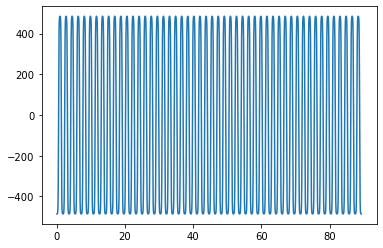

In [3]:
from flopping_mode_setup import default_par_dict, AmplitudeValueFunc, calculate_resonance_rabi_freq, time_and_steps_guess

# Start by loading the default parameters
parameter_dict = copy.deepcopy(default_par_dict)

def calculate_pulse_parameters(parameter_dictionary):
    """
    This function combines various steps of the analytical calculations linked
    to the model. First the expected Rabi frequency and the required resonance
    frequency are calculated. Then the time discretization is determined.

    The computed values are stored in the parameter dictionary.

    Parameters
    ----------
    parameter_dictionary: dict
        Contains all parameters required for the calculation.

    """
    resonance_frequency_guess, rabi_frequency_guess = \
            calculate_resonance_rabi_freq(**parameter_dictionary)
    parameter_dictionary["resonance_frequency_guess"] = resonance_frequency_guess
    parameter_dictionary["rabi_frequency_guess"] = rabi_frequency_guess

    n_time_steps, total_time_guess = time_and_steps_guess(**parameter_dictionary)
    parameter_dictionary["n_time_steps"] = n_time_steps
    parameter_dictionary["total_time_guess"] = total_time_guess

    parameter_dictionary['resonance_time_guess'] = 2 * np.pi / resonance_frequency_guess
    time = (total_time_guess / n_time_steps) * np.ones(n_time_steps)
    parameter_dictionary['acc_time'] = np.cumsum(time)

calculate_pulse_parameters(parameter_dict)

amp_func = AmplitudeValueFunc(**parameter_dict)
# The amplitude function 'amp_func' returns all

plt.plot(parameter_dict['acc_time'], amp_func(np.asarray([[.1, 1]]))[:, 0], )


Note, that the amplitude function 'amp_func' also returns values for the other amplitudes in the Hamiltonian, like the Zeeman splitting or tunnel coupling. This is linked to the fact that an effective optimization of the total pulse time is included by a time stretching parameter. Therefore, terms like the Zeeman splitting need to be treated as part of the control Hamiltonian and cannot be assumed to be part of the constant drift Hamiltonian.

## Energy Spectrum

Next, let's plot the energy spectrum of the model Hamiltonian to get a sense of the system.

<AxesSubplot:xlabel='Detuning ($\\mu$eV)'>

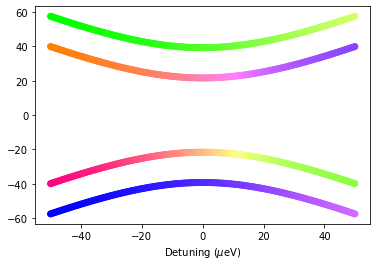

In [4]:
from flopping_mode_setup import create_hamiltonian, \
        micro_eV_by_inverse_nano_seconds, milli_tesla_Si_by_inverse_nano_seconds
from typing import List


# For illustration, we choose a very small tunnel coupling and a large zeeman
# energy. These values are not favorable for the operation of flopping-mode EDSR
# in the strong driving regime.
parameter_dict['tunnel_coupling'] = 20 * micro_eV_by_inverse_nano_seconds
parameter_dict['e_zeeman'] = 100 * milli_tesla_Si_by_inverse_nano_seconds

eps_range = np.linspace(
        -50 * micro_eV_by_inverse_nano_seconds,
        50 * micro_eV_by_inverse_nano_seconds,
        200
)

hamiltonians = [create_hamiltonian(
        tunnel_coupling=parameter_dict['tunnel_coupling'],
        eps=e,
        gmubbx=parameter_dict['gmubbx'],
        gmubbz=parameter_dict['gmubbz'],
        e_zeeman=parameter_dict['e_zeeman']
) for e in eps_range
]

# To enjoy the colors of the 'plot_energy_spectrum' functions,
# we need to transform to a meaningful basis.
def eig_basis_of_first_element(hamiltonians: List[DenseOperator]):
    """
    Convenience function for the plotting of energy spectra.

    Transform all hamiltonians into the eigenbasis of the first hamiltonian.
    """
    _, eig_vecs = hamiltonians[0].spectral_decomposition(hermitian=True)
    eigenbasis = DenseOperator(eig_vecs)
    hamiltonians_eig_basis_detuning = [eigenbasis.dag() * h * eigenbasis for h in hamiltonians]
    return hamiltonians_eig_basis_detuning

hamiltonians = eig_basis_of_first_element(hamiltonians)

plot_energy_spectrum(
        hamiltonian=hamiltonians,
        x_val=eps_range / micro_eV_by_inverse_nano_seconds,
        x_label="Detuning ($\mu$eV)"
)


For the chosen parameters, one can observe four seperated energy bands. The coloring represents the composition of the eigenvectors in the eigenbasis at $\epsilon =-50 \mu$eV, showing how the eigenvectors change at the avoided crossing.

## Pre-optimization

Next, I want to prepare the simulation of the system. I changed the parameters back to a favorable configuration, and calculate all quantities required for the model.

In [5]:
from flopping_mode_setup import estimate_default_bounds, estimate_default_initial_cond, create_coherent_state_simulator

# reset to more suitable values
parameter_dict['tunnel_coupling'] = 100 * micro_eV_by_inverse_nano_seconds
parameter_dict['e_zeeman'] = 20 * milli_tesla_Si_by_inverse_nano_seconds

calculate_pulse_parameters(parameter_dict)

parameter_dict['bounds'] = estimate_default_bounds(**parameter_dict)
parameter_dict['initial_control_amplitudes'] = \
    estimate_default_initial_cond(**parameter_dict)

# To save computational time, we will not estimate the optimization landscape in detail,
# but this would be required for a reliable optimization.
parameter_dict['get_init_val_grid'] = False

coherent_state_simulator, coherent_state_simulator_ex_leakage = \
    create_coherent_state_simulator(**parameter_dict)

## State Projections

Let's start with the simulation of the initial parameters and plot the projection of the system's instantaneous state. I plot the projections onto the vectors in the eigenbasis at the rest position ordered by ascending eigenvalue. 0 is the systems ground state. 1 has an excited spin state and an orbital ground state. 2 has an excited orbital state but spin ground state and 3 has an excited orbital and spin state.

One can observe the fast transitions between states of the same spin and different orbital state. For example, the transitions between blue and green occur when the electron travels between the left and right quantum dot while being in the spin ground state. The same holds true for the excited spin state and the orange and red curve.

The slow transition between the spin ground states (blue and green) and the spin exited states (orange and red) is the transition driven by the pulse.

Infidelity before the pulse optimization: 
[0.00569293 0.00569293]
Duration single execution: 21.032400131225586


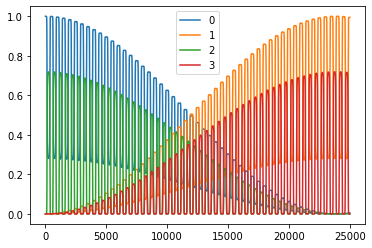

In [6]:
start = time.time()
costs = coherent_state_simulator.wrapped_cost_functions(
    parameter_dict['initial_control_amplitudes']
)
print('Infidelity before the pulse optimization: ')
print(costs)
end = time.time()
print('Duration single execution: ' + str(end - start))

propagators = coherent_state_simulator.solvers[0].forward_propagators

for i in range(4):
    projections = np.asarray([np.abs(prop[i]) ** 2 for prop in propagators])
    plt.plot(projections, label=str(i))
plt.legend()

## Full Optimization

The optimization is performed with a state simulator, meaning that we set the ground state as initial state and calculate the propagation of this state. (Later we will calculate the full propagator. )

Optimization duration: 1043.2460470199585
Optimal Parameters: 
[[0.19450944 0.99957047]]


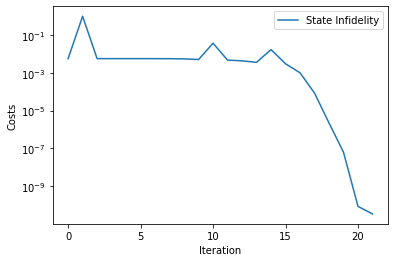

In [8]:
parameter_dict['save_intermediary_steps'] = True

optimizer = ScalarMinimizingOptimizer(
    system_simulator=coherent_state_simulator_ex_leakage,
    save_intermediary_steps=parameter_dict['save_intermediary_steps'],
    bounds=parameter_dict['bounds'],
    termination_cond=parameter_dict['termination_conditions']
)
start = time.time()
result = optimizer.run_optimization(
    initial_control_amplitudes=parameter_dict['initial_control_amplitudes']
)
parameter_dict['final_parameters'] = result.final_parameters
end = time.time()
print('Optimization duration: ' + str(end - start))

data = DataContainer()
data.append_optim_result(result)
analyser = Analyser(data)
analyser.plot_costs()

print('Optimal Parameters: ')
print(result.final_parameters)

In [7]:
# As alternative to the optimization, the result can be set directly:
parameter_dict['final_parameters'] = np.asarray([[0.19450944, 0.99957047]])


The optimization of a single configuration took already about 16 minutes and the full plots in the article cannot be reproduced without a considerable computational power.

## Calculation of the Propagator

Next we can calculate the full unitary propagator using a gate_simulator instead of a state_simulator. Since we only optimized a state fidelity, the full propagator is only an $X_\pi$-gate up to a z-rotation. We can calculate the angle between the actually simulated gate and an $X_\pi$-gate.

In [8]:
from flopping_mode_setup import calculate_opt_azimuth_angle, create_coherent_gate_simulator

def calculate_coherent_gate_infid(parameter_dictionary):
    """
    Calculate the coherent gate infidelity and leakage. Store them together
    with the total propagator.

    Parameters
    ----------
    parameter_dictionary: dict
        Pulse parameters.

    Returns
    -------
    parameter_dictionary: dict
        Pulse parameters.

    """

    if parameter_dictionary['use_opt_azimuth_angle'] \
            and parameter_dictionary['opt_azimuth_angle'] is None:
        calculate_opt_azimuth_angle_dict(parameter_dictionary)

    simulator_gate_leakage, simulator_gate_infid = \
        create_coherent_gate_simulator(**parameter_dictionary)

    eval_params = parameter_dictionary['final_parameters']

    for index, sim in zip(
        ['gate_leakage', 'gate_infid'],
        [simulator_gate_leakage, simulator_gate_infid]
    ):
        parameter_dictionary[index] = sim.wrapped_cost_functions(eval_params)

    parameter_dictionary['total_propagator'] = \
        simulator_gate_leakage.solvers[0].forward_propagators[-1]

    return parameter_dictionary


def calculate_opt_azimuth_angle_dict(parameter_dictionary):
    """
    Calculates the closest azimuth angle describing the quantum gate resulting
    from the optimized pulse.

    Parameters
    ----------
    parameter_dictionary: dict
        Pulse parameters.

    Returns
    -------
    parameter_dictionary: dict
        Pulse parameters.

    """
    if 'total_propagator' not in parameter_dictionary:
        # If the total propagator has not yet been calculated, then
        # we need to do so, before we can calculate the optimal azimuth
        # angle.
        temp_dict = copy.deepcopy(parameter_dictionary)
        temp_dict['use_opt_azimuth_angle'] = False
        calculate_coherent_gate_infid(temp_dict)
        parameter_dictionary['total_propagator'] = temp_dict['total_propagator']
    opt_azimuth_angle = calculate_opt_azimuth_angle(**parameter_dictionary)
    parameter_dictionary['opt_azimuth_angle'] = opt_azimuth_angle

calculate_coherent_gate_infid(parameter_dict)
print('Additional z-rotation of the propagator by: ' + str(parameter_dict['opt_azimuth_angle']))

Additional z-rotation of the propagator by: -0.0063048730188260856


If we correct the simulated gate for the z-rotation, by giving the pulse a phase shift, the resulting gate becomes.

In [11]:
temp_dict = copy.deepcopy(parameter_dict)

temp_dict['phase_shift'] = parameter_dict['opt_azimuth_angle']
temp_dict['use_opt_azimuth_angle'] = False
temp_dict = calculate_coherent_gate_infid(temp_dict)

propagator = temp_dict['total_propagator']

print('Deviation from the ideal gate without '
      'compensation of the z-rotation: ')
infid = entanglement_fidelity(
    target=DenseOperator.pauli_x().exp(-.5j * np.pi),
    propagator=parameter_dict['total_propagator'],
    computational_states=[0, 1],
    map_to_closest_unitary=False
)
print(1 - infid)

print('Deviation from the ideal gate with pulse shift: ')
infid = entanglement_fidelity(
    target=DenseOperator.pauli_x().exp(-.5j * np.pi),
    propagator=propagator,
    computational_states=[0, 1],
    map_to_closest_unitary=False
)
print(1 - infid)

Deviation from the ideal gate without compensation of the z-rotation: 
3.975267343792055e-05
Deviation from the ideal gate with pulse shift: 
7.664584522615314e-10


We can even create an orthogonal gate set by applying the phase shifts $\pm \pi/4$.

In [12]:
orthogonal_propagators = []
for phase_shift in [.25 * np.pi, -.25 * np.pi]:
    temp_dict = copy.deepcopy(parameter_dict)
    temp_dict['phase_shift'] = phase_shift
    temp_dict['use_opt_azimuth_angle'] = False
    temp_dict = calculate_coherent_gate_infid(temp_dict)
    orthogonal_propagators.append(temp_dict['total_propagator'])


In [13]:
print('Fidelity between the presumably orthogonal gates: ')
fidelity = entanglement_fidelity(
    target=orthogonal_propagators[0][:2, :2],
    propagator=orthogonal_propagators[1][:2, :2],
)
print(fidelity)

Fidelity between the presumably orthogonal gates: 
2.9558158268489867e-05


Finally, we can include quasi-static noise in the simulation:

In [14]:
from flopping_mode_setup import create_mc_gate_simulator
simulator_chrg_noise_infid, simulator_chrg_noise_leakage, \
        simulator_res_noise_infid, simulator_res_noise_leakage = \
        create_mc_gate_simulator(**parameter_dict)

parameter_dict['chrg_noise_infid'] = \
    simulator_chrg_noise_infid.wrapped_cost_functions(parameter_dict['final_parameters'])

print('The infidelity in the presence of quasi-static noise is: ' + str(parameter_dict['chrg_noise_infid'] ))

The infidelity in the presence of quasi-static noise is: [1.63039116e-06]


## Further Comments

The simulation of the fast noise model works similar and the required functions are available in the setup file.